# Сравнение данных с реанализом cfs2

In [2]:
import os
import numpy as np
import pandas as pd

from netCDF4 import Dataset
import datetime
import calendar
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import cm
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

## Формирование временного ряда из ячейки реанализа

In [3]:
from meteotik.utils import cfs2_prepare_data

* Ура-Губа 22018 69° 17' с.ш., 32° 48' в.д.; 27 м -- (69.283 с.ш.; 32.80 в.д.) -> не интерполированные данные (69.283; 212.8)
* Полярный 22019 69° 12' с.ш., 33° 28.823999999999998' в.д.; 13 м -- (69.20 с.ш.; 33.48 в.д.) -> не интерполированные данные (69.20; 213.48)

In [ ]:
# Подготавливаем временной ряд для метеостанции
cfs2_prepare_data(path = '//10.9.14.114/calc/Nikitin/novatek/rean/cfs2', 
                  files = ['wind_ura_2019-03-01.nc', 'wind_ura_2019-04-01.nc'],
                  coords={'lat':69.283,'lon':32.80}, 
                  where_to_save = 'D:/ura-guba/meteo/cfs_ura', 
                  change_timestap = False, vis = False)

Processing... wind_ura_2019-03-01.nc


In [ ]:
# Подготавливаем временной ряд для метеостанции
cfs2_prepare_data(path = '//10.9.14.114/calc/Nikitin/novatek/rean/cfs2', 
                  files = ['wind_ura_2019-03-01.nc', 'wind_ura_2019-04-01.nc'],
                  coords={'lat':69.20,'lon':33.48}, 
                  where_to_save = 'D:/ura-guba/meteo/cfs_pol', 
                  change_timestap = False, vis = False)

In [38]:
from meteotik.utils import make_era_dataframe

# Составляем датасеты по данным реанализа
cfs_ura = make_era_dataframe('D:/ura-guba/meteo/cfs_ura')
cfs_pol = make_era_dataframe('D:/ura-guba/meteo/cfs_pol')
cfs_ura['Date'] = pd.to_datetime(cfs_ura['Date'])
cfs_pol['Date'] = pd.to_datetime(cfs_pol['Date'])
cfs_pol.head(3)

,U,V,Date
0,6.74,-1.91,2019-04-01 03:00:00
1,8.67,0.58,2019-04-01 09:00:00
2,5.43,-1.91,2019-04-01 15:00:00


## Временной ряд с метеостанций с rp5

In [39]:
data_ura = pd.read_excel('D:/ura-guba/meteo/Ura_guba_22018.xls', comment = '#')
data_ura = data_ura[['Местное время в Ура-Губе', 'DD', 'Ff']]
data_ura = data_ura.rename(columns={'Местное время в Ура-Губе': 'Date',
                                    'DD': 'Direction',
                                    'Ff': 'Velocity'})
data_ura['Date'] = pd.to_datetime(data_ura['Date'], format = '%d.%m.%Y %H:%M')

# Удаление пустых строк
data_ura.dropna(inplace=True)

In [40]:
data_pol = pd.read_excel('D:/ura-guba/meteo/Polarniy_22019.xls', comment = '#')
data_pol = data_pol[['Местное время в Полярном', 'DD', 'Ff']]
data_pol = data_pol.rename(columns={'Местное время в Полярном': 'Date',
                                    'DD': 'Direction',
                                    'Ff': 'Velocity'})
data_pol['Date'] = pd.to_datetime(data_pol['Date'], format = '%d.%m.%Y %H:%M')

# Удаление пустых строк
data_ura.dropna(inplace=True)

In [41]:
# Функция для перевода текстового описания направления ветра в градусы
# 0 - кодируется штиль
# 360 - северный румб
from meteotik.utils import parse_direction

In [42]:
codes = parse_direction(column=list(data_ura['Direction']))
data_ura['Direction'] = codes
data_ura.head(3)

,Date,Direction,Velocity
0,2019-04-30 21:00:00,360.0,4
1,2019-04-30 15:00:00,270.0,5
2,2019-04-30 09:00:00,225.0,4


In [43]:
codes = parse_direction(column=list(data_pol['Direction']))
data_pol['Direction'] = codes
data_pol.head(3)

,Date,Direction,Velocity
0,2019-04-30 21:00:00,45.0,8
1,2019-04-30 15:00:00,270.0,6
2,2019-04-30 09:00:00,270.0,3


### Расчет U и V компонент

In [44]:
from meteotik.utils import calculate_uv

In [45]:
data_ura = calculate_uv(data_ura, 'Velocity', 'Direction')
data_ura['Date'] = pd.to_datetime(data_ura['Date'])
data_ura.head(3)

,Date,Direction,Velocity,U,V
0,2019-04-30 21:00:00,360.0,4,9.797174e-16,-4.000000e+00
1,2019-04-30 15:00:00,270.0,5,5.000000e+00,9.184851e-16
2,2019-04-30 09:00:00,225.0,4,2.828427e+00,2.828427e+00


In [46]:
data_pol = calculate_uv(data_pol, 'Velocity', 'Direction')
data_pol['Date'] = pd.to_datetime(data_pol['Date'])
data_pol.head(3)

,Date,Direction,Velocity,U,V
0,2019-04-30 21:00:00,45.0,8,-5.656854,-5.656854e+00
1,2019-04-30 15:00:00,270.0,6,6.000000,1.102182e-15
2,2019-04-30 09:00:00,270.0,3,3.000000,5.510911e-16


### Объединение датафреймов для Ура-Губы

In [47]:
data_ura = data_ura.rename(columns={'U': 'U_meteo',
                                    'V': 'V_meteo'})
ura_df = cfs_ura.merge(data_ura, on = 'Date')

In [48]:
data_pol = data_pol.rename(columns={'U': 'U_meteo',
                                    'V': 'V_meteo'})
pol_df = cfs_pol.merge(data_pol, on = 'Date')

## Метеостанция Ура-Губа

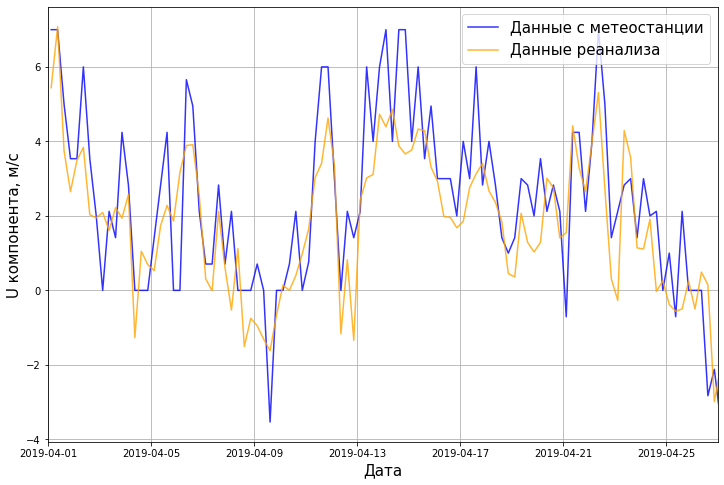

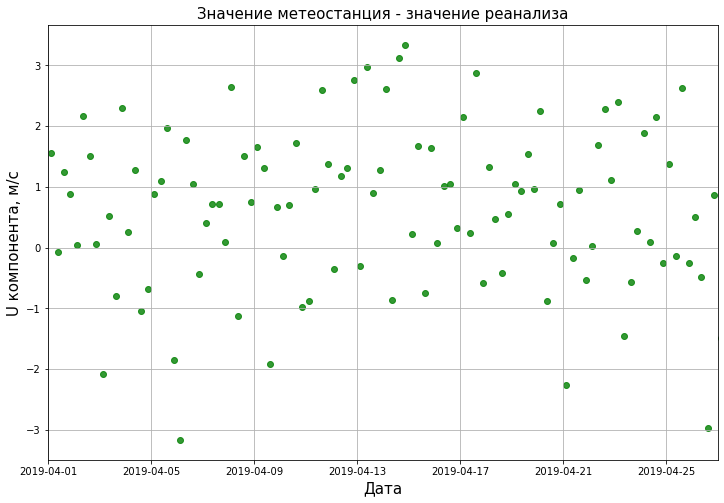

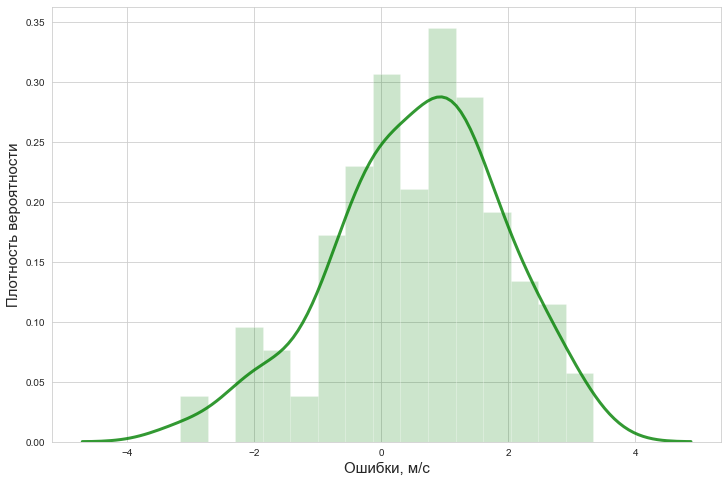

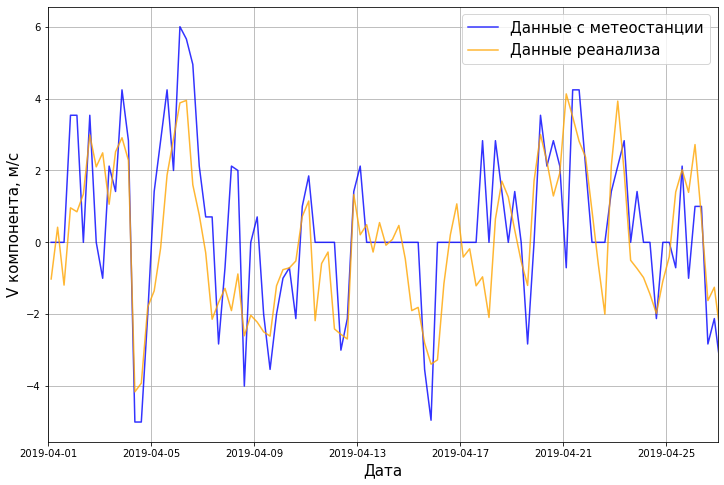

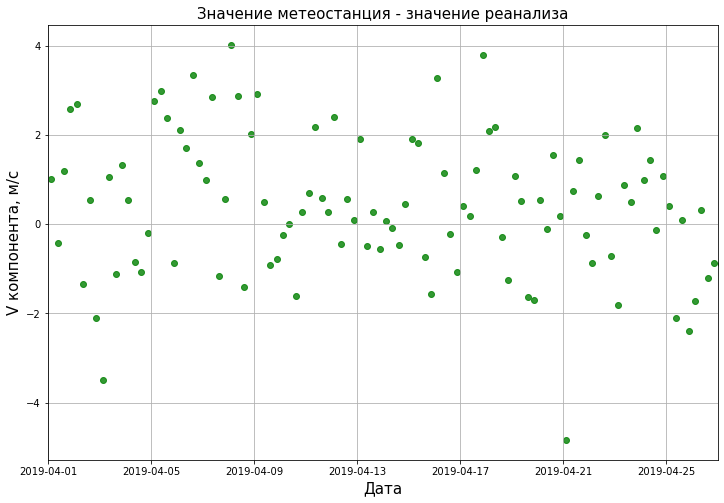

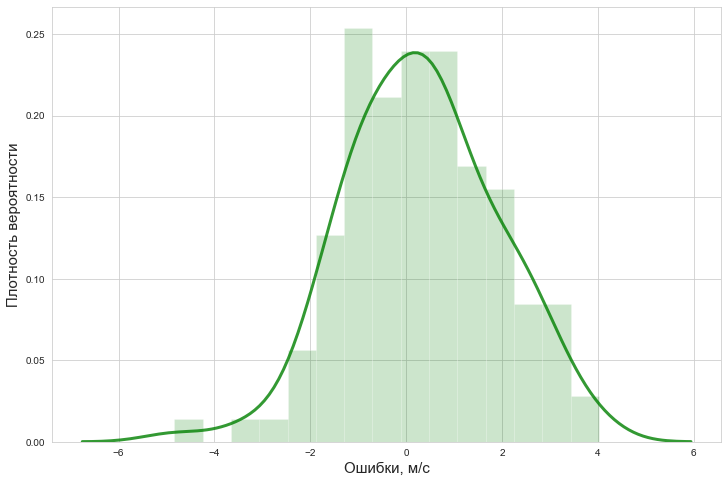

Среднаяя абсолютная ошибка, м/с для U - 1.17 и V - 1.27
Коэффициент корреляции для U - 0.83 и V - 0.73


In [49]:
from meteotik.utils import make_comparison
make_comparison(ura_df, x_min='2019-04-01', x_max='2019-04-27')

Смещение для U компоненты, м/с: -0.57
Смещение для V компоненты, м/с: -0.31
Смещение для скорости ветра, м/с: -0.59 

Среднаяя абсолютная ошибка, м/с для U: 1.17
Среднаяя абсолютная ошибка, м/с для V: 1.27
Среднаяя абсолютная ошибка, м/с для скорости ветра: 1.12 

Коэффициент корреляции для U: 0.83
Коэффициент корреляции для V: 0.73
Коэффициент корреляции для скорости ветра: 0.73
75й квантиль для скорости ветра 5.0, среднее значение - 3.48, 25й квантиль 2.0


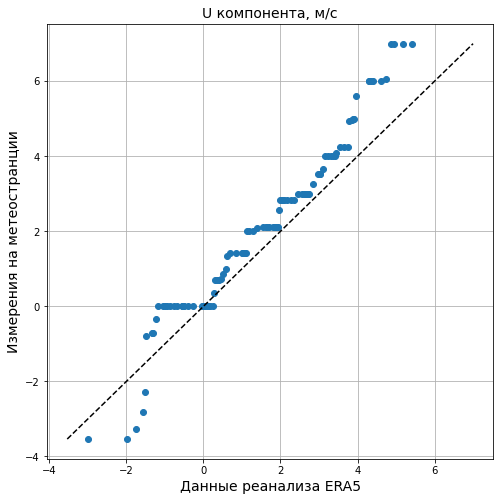

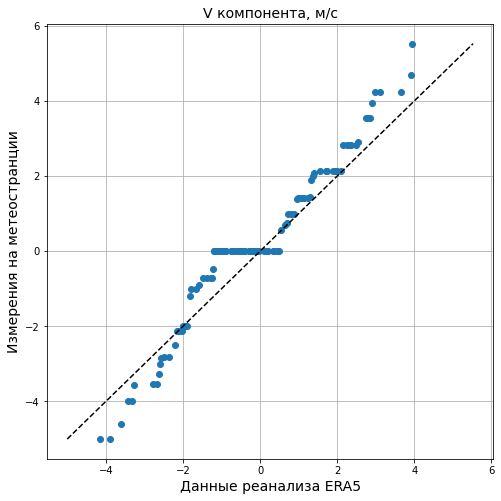

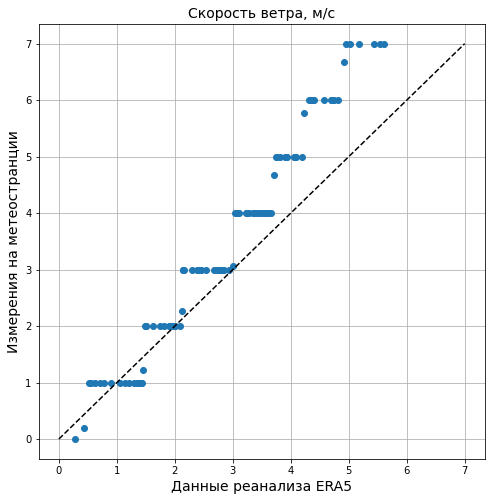

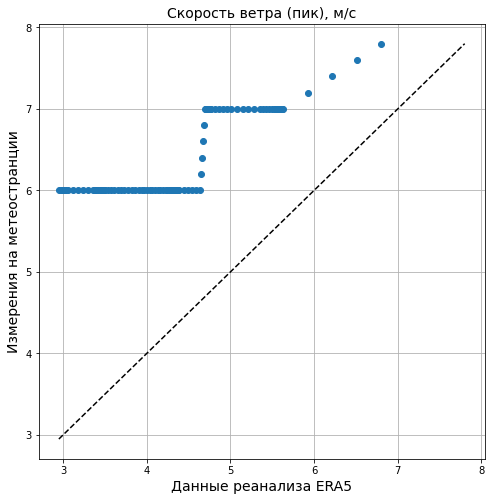

Доля наблюдений со штилем 1.7%


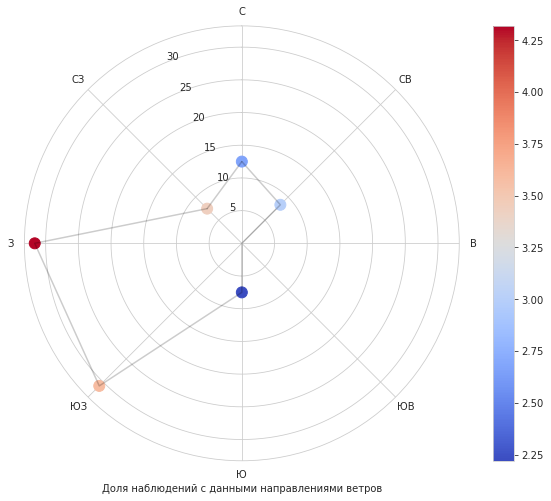

In [50]:
from meteotik.utils import print_statistics, prepare_csv

print_statistics(ura_df)
prepare_csv(ura_df, where_to_save = 'D:/ura-guba/meteo/Ura_report_cfs.csv')

## Метеостанция Полярный

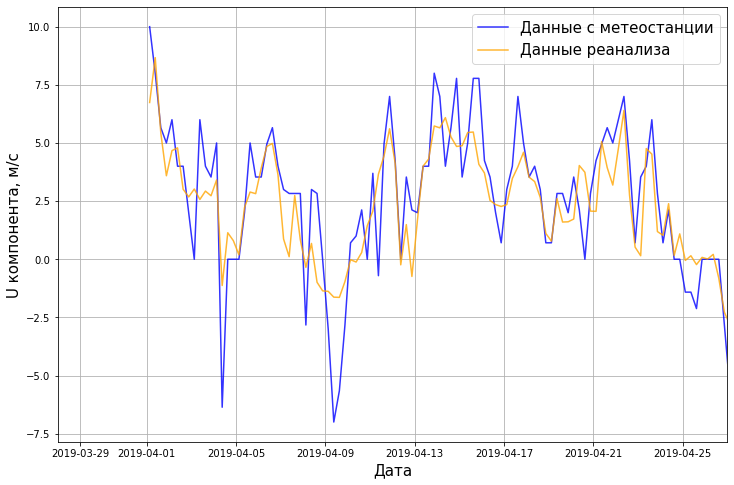

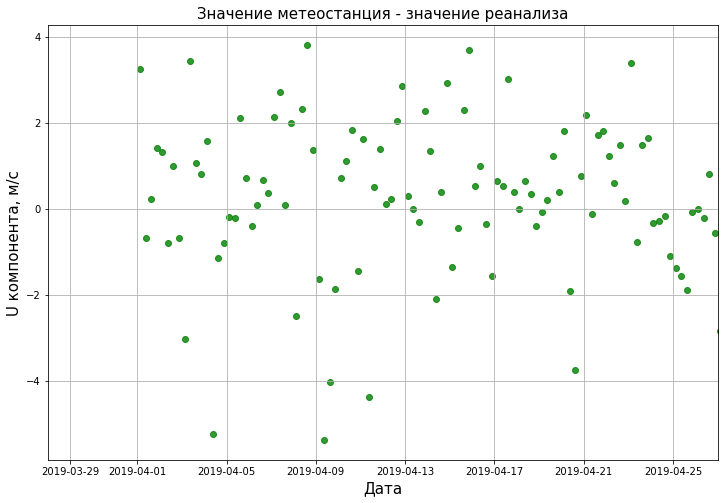

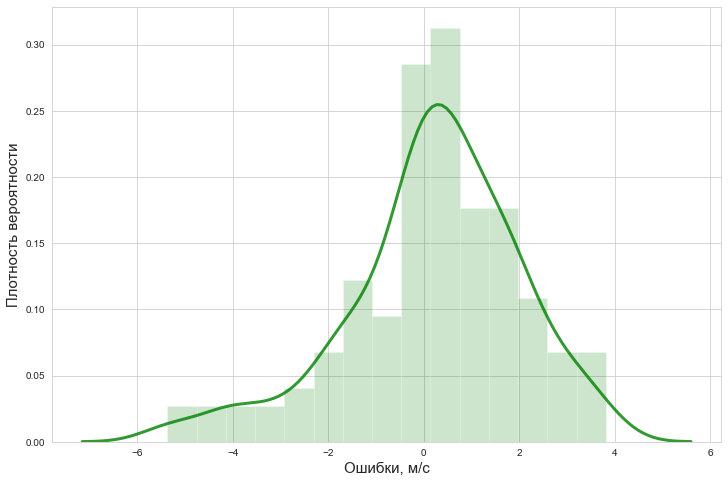

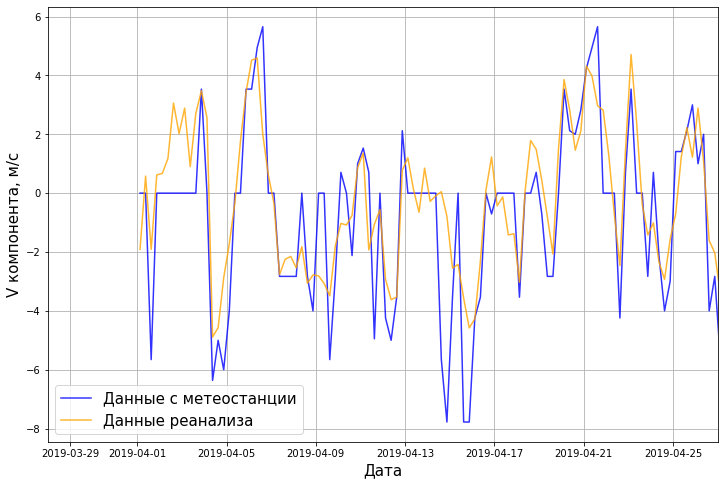

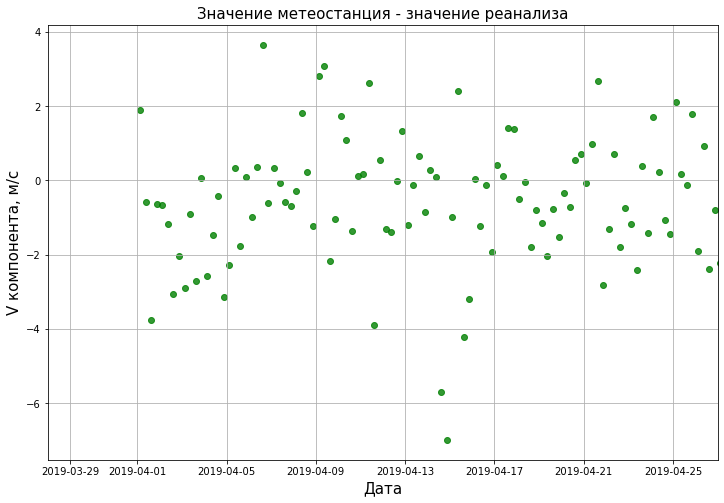

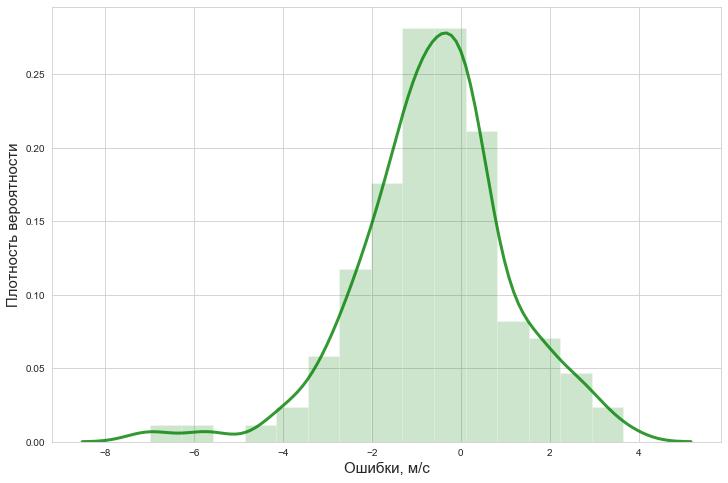

Среднаяя абсолютная ошибка, м/с для U - 1.39 и V - 1.31
Коэффициент корреляции для U - 0.84 и V - 0.82
Смещение для U компоненты, м/с: -0.20
Смещение для V компоненты, м/с: 0.59
Смещение для скорости ветра, м/с: -0.90 

Среднаяя абсолютная ошибка, м/с для U: 1.39
Среднаяя абсолютная ошибка, м/с для V: 1.31
Среднаяя абсолютная ошибка, м/с для скорости ветра: 1.43 

Коэффициент корреляции для U: 0.84
Коэффициент корреляции для V: 0.82
Коэффициент корреляции для скорости ветра: 0.72
75й квантиль для скорости ветра 6.0, среднее значение - 4.48, 25й квантиль 3.0


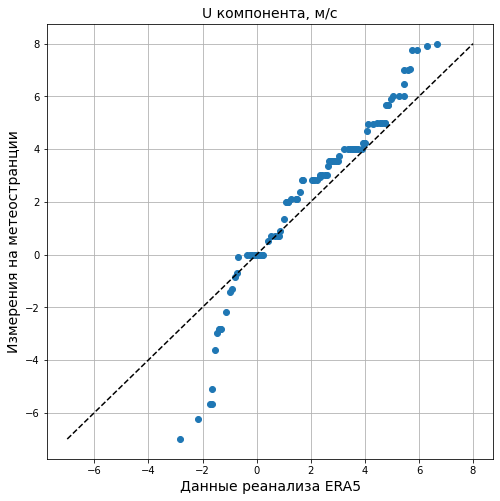

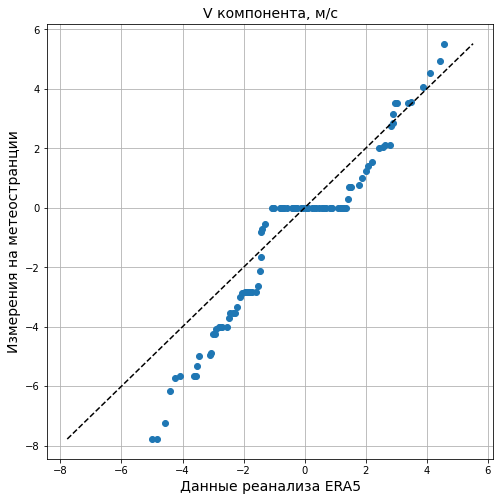

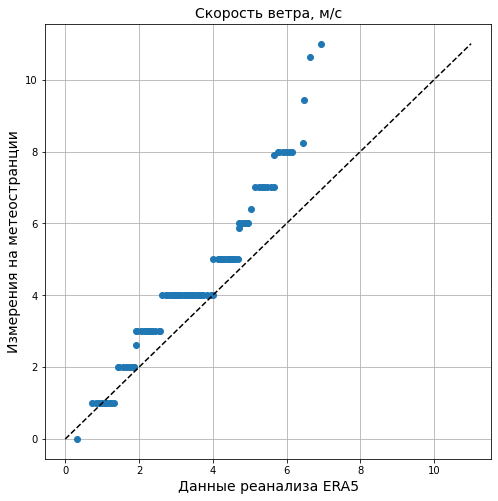

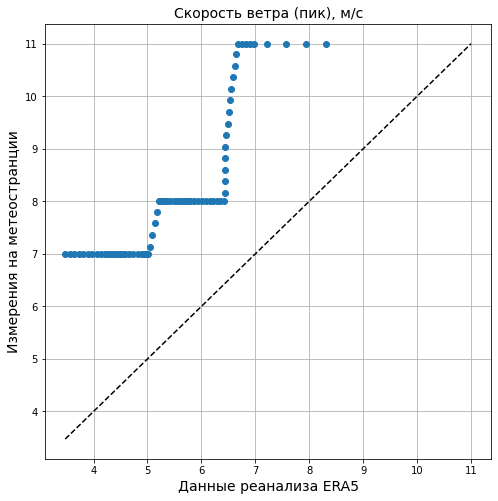

Доля наблюдений со штилем 0.8%


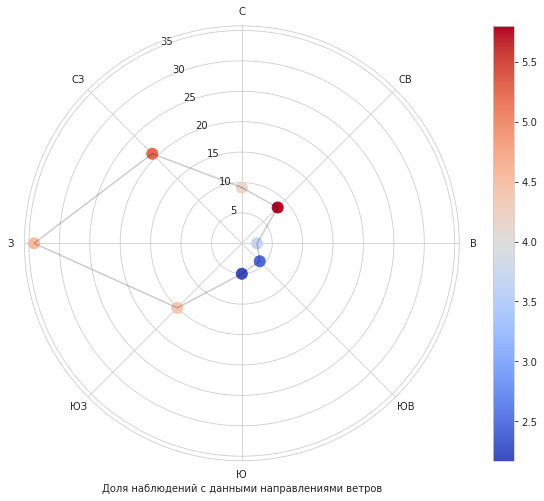

In [51]:
make_comparison(pol_df)
print_statistics(pol_df)
prepare_csv(pol_df, where_to_save = 'D:/ura-guba/meteo/Pol_report_cfs.csv')